In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pymatgen.core import Structure, Element
import pandas as pd
from data_scripts.crystal_structure_conversion import ase_to_pymatgen
import time
import datetime
from atomic_feature_func import *
from typing import Tuple
import os
from pymatgen.core import Element

In [2]:
df = pd.read_pickle("_coSchAl1.pkl")

In [3]:
df['pyst']=df.atoms.map(ase_to_pymatgen)

In [9]:
df['oxidation'] =np.NaN
df['sc'] = np.NaN

In [10]:
def analyze_env_light(struc : Structure, mystrategy : str = "simple") -> Tuple[List[int], StructureConnectivity]:
    '''Analyzes the coordination environments and returns the LightStructureEnvironment (LSE) object for the crystal and the list of oxidation states.
    First, BVAnalyzer() calculates the oxidation states. Then, the LocalGeometryFinder() computes the structure_environment object, 
    from which the LightStructureEnvironment (LSE) is derived.     
    This light function DOES NOT return StructureConnectivity (SE).
    Parameters:
    ----------------
    struc : Structure 
        crystal Structure object from pymatgen
    mystrategy : string
	    The simple or combined strategy for calculating the coordination environments.
'''
    if mystrategy == "simple":
        strategy = SimplestChemenvStrategy(distance_cutoff=1.5, angle_cutoff=0.1)
        # strategy = SimplestChemenvStrategy(distance_cutoff=1.4, angle_cutoff=0.3)
    else:
        strategy = mystrategy
        
    # struc = datum["structure"]
    bv = BVAnalyzer()  #This class implements a maximum a posteriori (MAP) estimation method to determine oxidation states in a structure.
    oxid_states = bv.get_valences(struc)
    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")  #to avoid printing to the console 
    lgf = LocalGeometryFinder() 
    # prints a long stroy every time it is initiated.
    sys.stdout = old_stdout # reset old stdout
    lgf.setup_structure(structure=struc)
    # Get the StructureEnvironments 
    # se = lgf.compute_structure_environments(only_cations=True,valences=oxid_states,
    se = lgf.compute_structure_environments(only_cations=False,valences=oxid_states,
    additional_conditions=[AdditionalConditions.ONLY_ANION_CATION_BONDS])
    # Get LightStructureEnvironments
    lse = LightStructureEnvironments.from_structure_environments(
    strategy=strategy, structure_environments=se)
    # Get StructreConnectuvuty object
    # cf= ConnectivityFinder()
    # sc=cf.get_structure_connectivity(light_structure_environments=lse)

    return oxid_states, lse

In [11]:
def batch_coord_light(pd_series , coord_problem : bool = True):
    '''Loops through a sequence of data analyzing the coordination environment. 
    Returns an array, each entity is a dictionary containing the features of one crystal structure.
    Parameters:
    ----------------
    data : Iterable
        The list/array of crystal data containing Structure and material_id
    coord_problem : bool
        Whether to report data points with a problem in analyzing their coordinates. 
    '''
    mycoord_problem = []
    tempList : list[dict] = [{} for _ in range(len(pd_series))]
    tempArray = np.array(tempList)
    del tempList

    # for j, datum in enumerate(data):
    for j,(material_id, struct )in enumerate(pd_series.iteritems()):
        try:
            oxid_states, lse = analyze_env_light(struc=struct, mystrategy="simple")
            tempArray[j]["oxidation"] = oxid_states
            tempArray[j]["lse"] = lse
            tempArray[j]["material_id"] = material_id
            tempArray[j]["struc"] = struct
        except:
            if coord_problem:
                mycoord_problem.append([material_id])
                print("Couldn't analyze valencce for ", material_id)
            else:
                print("Couldn't analyze valencce for ", material_id,)
    return mycoord_problem, tempArray


In [12]:
def lightNBfeats(lse_object, oxidation_list , struct : Structure) -> dict:
    structure_data : dict = {}
    for atomIndex, atom in enumerate(lse_object.neighbors_sets):
        angles = []    
        structure_data[atomIndex] = {}
        structure_data[atomIndex]['oxidation'] = oxidation_list[atomIndex]
       
        structure_data[atomIndex]['element'] = struct[atomIndex].species_string
        structure_data[atomIndex]['coords'] = struct[atomIndex].coords
        # structure_data[atomIndex]['localEnv'] = local_Envs_list[atomIndex]#[0] return a list including a single dict. Shoulbe be multiple dicts in the compound strategy.
        neighbors = atom[0].neighb_sites_and_indices
        structure_data[atomIndex]['NN_distances'] = []
        for k in range(len(neighbors)):
            nb=neighbors[k]
            nb_element = nb['site'].species_string
            nb_distance = nb['site'].distance_from_point(struct[atomIndex].coords)
            structure_data[atomIndex]['NN_distances'].append([nb_distance,nb_element])
            for k2 in range(k+1, len(neighbors)):
                nb2 = neighbors[k2]
                angle = get_angle(struct[atomIndex].coords-nb['site'].coords,
                                struct[atomIndex].coords-nb2['site'].coords)
                angles.append(angle)
                    
        structure_data[atomIndex]['nbs']=neighbors
        structure_data[atomIndex]['angles']=angles
    return structure_data


In [13]:
currentLoc='/home/samariam/projects/synth/heuristics_analysis'
os.chdir(currentLoc)
subdirectory = "data_chunks"
# os.makedirs(subdirectory, exist_ok=True)

In [15]:
os.path.exists(currentLoc + data_chunk_name + '.npy')

False

In [20]:
os.path.exists(os.path.join(currentLoc, data_chunk_name+'.npy'))

False

In [19]:
os.path.join(currentLoc, data_chunk_name+'.npy')

'/home/samariam/projects/synth/heuristics_analysis/coordata_1.npy'

In [24]:
'/home/samariam/projects/synth/heuristics_analysis/data_chunks/coordata_1.npy'==os.path.join(currentLoc, subdirectory,data_chunk_name+'.npy')

True

In [33]:
chunkSize = 1000

coord_problem = []
data_chunk_list = []
for i,chunk in enumerate(chunker(df.pyst,chunkSize)):
    data_chunk_name = "coordata_" + str(i)
    data_chunk_list.append(data_chunk_name + '.npy') 
    if os.path.exists(os.path.join(currentLoc, subdirectory,data_chunk_name+'.npy')): ###COMMENT THIS OUT if you want to overwrite previous data!!!!!!!!
        continue
    print('calculating coordination for the range', i*chunkSize, 'to', min((i+1)*chunkSize, len(df)))
    chunkCoord_problem, tempArray = batch_coord_light(chunk, coord_problem=True)
    coord_problem.append(chunkCoord_problem)  #unravel this list later
    np.save(os.patin(currentLoc,subdirectory,data_chunk_name)
            , tempArrah.joy)
    if i == 1:
        break
    del tempArray

In [44]:
print("Files to be featurized are", *data_chunk_list )
# the separation is there to delete the tempArray and not to overflow the memory
crystal_features = np.empty(0)  #to initiate appending data below
for i,data_chunk_name in enumerate(data_chunk_list):
    print('Featurizing data chunk ', data_chunk_name)
    res= []
    lse_data = np.load(os.path.join(currentLoc,subdirectory,data_chunk_name ),
                      allow_pickle=True)
    print('Calculating features for ', data_chunk_name  )
    for j,crystal in enumerate(lse_data):
        if j%100==0:
            print('Data #', j)
        try:
            lse = crystal['lse']
            oxid_states = crystal["oxidation"]
            material_id = crystal['material_id']
            structure = crystal['struc']
            res.append({'feats' :lightNBfeats(lse,oxid_states, structure), 'material_id':material_id })
        except:
            continue
    np.save(os.path.join(currentLoc,subdirectory,'tmp_feats'),np.array(res))
    with open(os.path.join(currentLoc,subdirectory,data_chunk_name+'_featurized.log'), 'w') as file:
        file.write('')
    crystal_features = np.concatenate((crystal_features,np.array(res)))  #collects the features of different chuncks of data.
    # break

Files to be featurized are coordata_2.npy coordata_3.npy coordata_4.npy coordata_5.npy coordata_6.npy coordata_7.npy coordata_8.npy coordata_9.npy coordata_10.npy coordata_11.npy coordata_12.npy coordata_13.npy coordata_14.npy coordata_15.npy coordata_16.npy coordata_17.npy coordata_18.npy coordata_19.npy coordata_20.npy coordata_21.npy coordata_22.npy coordata_23.npy coordata_24.npy coordata_25.npy coordata_26.npy coordata_27.npy coordata_28.npy coordata_29.npy coordata_30.npy coordata_31.npy coordata_32.npy coordata_33.npy coordata_34.npy coordata_35.npy coordata_36.npy coordata_37.npy coordata_38.npy coordata_39.npy coordata_40.npy coordata_41.npy
0
Calculating features for  coordata_2.npy
Data number 0
Data number 10
Data number 20
Data number 30
Data number 40
Data number 50


KeyError: 'lse'

In [259]:
angles_dict = {
    '2':[180], 
    '3':[120,120,120], 
    '4': [109.5, 109.5,109.5,109.5,109.5,109.5], 
    '5':[90,90,90,90,90,90,120,120,120,180],
    '6':[90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 180, 180, 180],
    '7':[72, 72, 72, 72, 72, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 144, 144, 144, 144, 144, 180],
 }
nb_nums = [2,3,4,5,6,7]

In [270]:
'2' in angles_dict

True

In [102]:
tmp = np.load('crystal_features.npy', allow_pickle=True)

In [103]:
len(tmp)

41115

In [108]:
tmp[0]['feats'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [125]:
stmp = [data for data in tmp if len(data['feats']) < 40]
# remove huge crystals

In [267]:
tmp[0]['feats'][0].keys()

dict_keys(['oxidation', 'element', 'coords', 'NN_distances', 'nbs', 'angles'])

In [292]:
aas = [80.10522397328603,
            117.66057013172147,
            82.37544840396032,
            89.72324679896883,
            125.31889255459755,
            59.801559402138494,
            155.222815088012,
            82.40041462259332,
            144.85135277224708,
            144.88445388550315,
            125.21293834160184,
            85.50218947330322,
            80.12455694118533,
            59.83440588467295,
            117.57911235559625]
sum(max(x - y, 0) for x, y in zip(angles_dict[str(len([[1.954702502353536, 'O'],
                  [2.7851757378460356, 'O'],
                  [1.932528163836433, 'O'],
                  [2.785175737846036, 'O'],
                  [1.949748819276943, 'O'],
                  [1.930100799520885, 'O']]))], aas))

342.5538421442953

In [325]:
for mat in stmp:
    angular_tension_tot = []
    for atom in mat['feats'].values():
        nb_num = len(atom['nbs'])
        if str(nb_num) in angles_dict:
            try:
                angular_tension = sum(max(x - y, 0) for x, y in zip(angles_dict[str(nb_num)], atom['angles']))
                atom['angular_tension'] = angular_tension
                angular_tension_tot.append(angular_tension)
                
            except:
               atom['angular_tension'] = np.NaN 
        else:
            atom['angular_tension'] = np.NaN
    mat['angular_tension_list'] = angular_tension_tot 
    mat['angular_tension_sum'] = np.sum(angular_tension_tot)
    mat['angular_tension_pera'] = mat['angular_tension_sum']/len(mat['feats'])
    
    # break

In [408]:
for mat in stmp:
    angular_tension_tot = []
    crystal_packing_list = []
    for atom in mat['feats'].values():
        elem = Element(atom['element'])
        elec = elem.X
        oxidation = atom['oxidation']
        atomic_rad = elem.atomic_radius
        if oxidation in elem.ionic_radii:
            ionic_rad = elem.ionic_radii[oxidation]
        else:
            ionic_rad = atomic_rad           
        
        atom_packing_list = []
        for j,nb in enumerate(atom['NN_distances']):
            distance = float(nb[0])
            # break
            nb_elem = Element(nb[1])
            nb_elec = nb_elem.X
            elec_diff = abs(nb_elec-elec)
            if elec_diff>1.7:
                nb_oxidation = mat['feats'][atom['nbs'][j]['index']]['oxidation']
                if nb_oxidation in nb_elem.ionic_radii:
                    nb_rad = nb_elem.ionic_radii[nb_oxidation]
                else:
                    nb_rad = nb_elem.atomic_radius
                radii_sum = float(ionic_rad) + float(nb_rad) # trouble with units, although both are angestrom
            else:
                nb_rad = nb_elem.atomic_radius
                radii_sum = float(atomic_rad) + float(nb_rad)
                
            nb_packing = distance - (radii_sum)
            atom_packing_list.append(nb_packing)
            # need to save this somewhere
                
        atom_packing = sum(abs(x) for x in atom_packing_list)
        crystal_packing_list.append(atom_packing)
        atom['atom_packing_list'] = atom_packing_list
        atom['atom_packing'] = atom_packing
    mat['crystal_packing'] = sum(crystal_packing_list)
                
    
    # break

In [474]:
# stmp[0].keys()
np.save('/home/samariam/projects/synth/heuristics_analysis/below40_featurized', stmp[0])

In [412]:
keys_to_keep = ['material_id', 'angular_tension_list', 'angular_tension_sum', 'angular_tension_pera', 'crystal_packing']
S_array = [{key: d[key] for key in keys_to_keep} for d in stmp]

In [413]:
newdf = pd.DataFrame.from_records(S_array)

In [418]:
# df.head(3)

In [419]:
newdf = newdf.merge(df, on='material_id', how='left')

In [447]:
edf = newdf[newdf.original_target==1]
tdf = newdf[newdf.original_target==0]
pdf = newdf[newdf.target_pd==1]
ndf = newdf[newdf.target_pd==0]

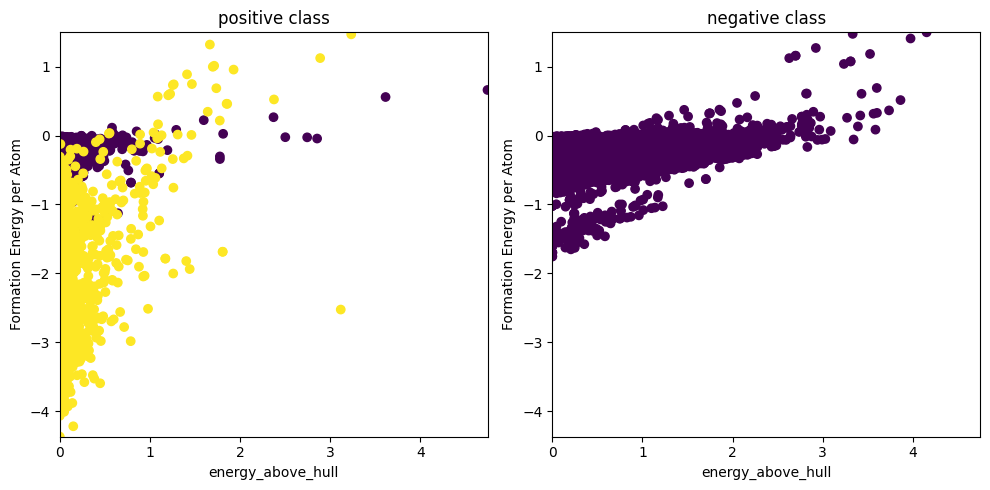

In [473]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Plot for the first dataframe (newdf1)
# pdf = 0
# ndf = 2

xlim = (min(min(pdf.energy_above_hull), min(ndf.energy_above_hull)),
        max(max(pdf.energy_above_hull), max(ndf.energy_above_hull)))
ylim = (min(min(pdf.formation_energy_per_atom), min(ndf.formation_energy_per_atom)),
        max(max(pdf.formation_energy_per_atom), max(ndf.formation_energy_per_atom)))


axes[0].scatter(pdf.energy_above_hull, pdf.formation_energy_per_atom,c=pdf.original_target)
axes[0].set_xlabel('energy_above_hull')
axes[0].set_ylabel('Formation Energy per Atom')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].set_title('positive class')

# Plot for the second dataframe (newdf2)
axes[1].scatter(ndf.energy_above_hull, ndf.formation_energy_per_atom, c=ndf.original_target)
axes[1].set_xlabel('energy_above_hull')
axes[1].set_ylabel('Formation Energy per Atom')
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_title('negative class')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig('/home/samariam/projects/synth/reports/cotraining_0/_coSchAl1.png', dpi=300)
plt.show()


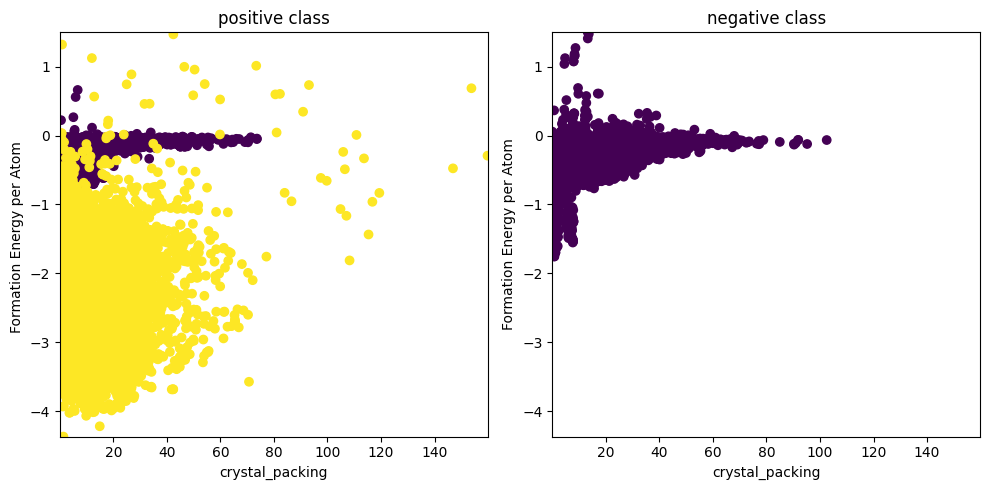

In [472]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# Plot for the first dataframe (newdf1)
# pdf = 0
# ndf = 2

ylim = (min(min(pdf.formation_energy_per_atom), min(ndf.formation_energy_per_atom)),
        max(max(pdf.formation_energy_per_atom), max(ndf.formation_energy_per_atom)))
xlim = (min(min(pdf.crystal_packing), min(ndf.crystal_packing)),
        max(max(pdf.crystal_packing), max(ndf.crystal_packing)))


axes[0].scatter(pdf.crystal_packing, pdf.formation_energy_per_atom,c =pdf.original_target)
axes[0].set_xlabel('crystal_packing')
axes[0].set_ylabel('Formation Energy per Atom ')
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)
axes[0].set_title('positive class')

# Plot for the second dataframe (newdf2)
axes[1].scatter(ndf.crystal_packing, ndf.formation_energy_per_atom,c =ndf.original_target )
axes[1].set_xlabel('crystal_packing')
axes[1].set_ylabel('Formation Energy per Atom')
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)
axes[1].set_title('negative class')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig('/home/samariam/projects/synth/reports/cotraining_0/_coSchAl1_packing.png', dpi=300)
plt.show()
